In [36]:
from pandas import Timedelta
import country_converter as coco
import numpy as np

#### **Import National Democratic Institute (NDI) dataset**
##### This dataset spans from 2006 until 2023

In [37]:
import pandas as pd
df_ndi = pd.read_parquet("../NDI/election_dates.parquet")

#### **Prepare NDI dataset**
1. Change the columns name to match the next dataset
2. Change the date type to date
3. Run countries through coco 
4. Uniformize election type names
5. Add column source

In [38]:
df_ndi.rename(columns = {'Election type': 'Election_type','date':'Date'}, inplace = True)

df_ndi["Date"] = pd.to_datetime(df_ndi["Date"])

df_ndi["Country"] = coco.convert(names=df_ndi["Country"], to='name_short')

matches_1 = [("Senatorial By-Election","Senatorial"), ("Presidential By-election", "Presidential")]

for x in matches_1:
    df_ndi["Election_type"] = df_ndi["Election_type"].str.replace(x[0], x[1])

df_ndi['Source'] = "NDI"

#### **Import Wikipedia dataset**
##### This dataset is for the years of 2013, 2015, 2016, 2017, and 2018.

In [40]:
df_wiki = pd.read_parquet('../Wiki elections parser/election_dates_wiki.parquet')

#### **Prepare Wikipedia dataset**
1. Run countries through coco
2. Uniformize election type with NDI dataset
3. Add column source

In [41]:
df_wiki["Country"] = coco.convert(names=df_wiki["Country"], to='name_short')

matches_2 = [('municipal election', 'Municipal'),('gubernatorial election', 'Gubernatorial') ,
             ('national assembly', 'National assembly'),('local elections', 'Local'),('constitutional referendum', 'Referendum'),
             ('legislative election', 'Legislative'),('parliamentary election','Parliamentary'), ('general election','General'),
             ('presidential election','Presidential')]

for x in matches_2:
    df_wiki["Election_type"] = df_wiki["Election_type"].str.replace(x[0], x[1])

df_wiki["Source"] = "Wikipedia"

#### **Join the datasets from the two sources**
Merging the NDI and the Wikipedia dataset. This is necessary given that when validating the NDI dataset, it became apparent that not all elections were posted there.

In [42]:
df_elections = pd.concat([df_ndi,df_wiki])

#### **Prepare the final election dataset**
1. Remove the time from the Date column
2. Drop the duplicate observations
3. Sort the dataset by Date

In [43]:
df_elections['Date'] = pd.to_datetime(df_elections['Date']).dt.date

df_elections.drop_duplicates(subset=["Country","Election_type","Date"],inplace=True)

#### **Import the Afrobarometer dataset**
Import rounds 2 through 7 of the Afrobarometer surveys. 

For each round we will:
1. Import only the variables of interest 
2. Run coco through the countries
3. Change the variable names
4. Merge all rounds

In [44]:
df_AB_2 = pd.read_spss("../Afrobarometer/r2_merged.sav", usecols=["q26a","q26b","q26c","dateintr","country"])
df_AB_2["country"] = coco.convert(names=df_AB_2["country"], to='name_short')
df_AB_2.rename(columns = {'q26a': 'Radio','q26b':'Television', 'q26c': 'Newspaper','dateintr': 'DATEINTR','country':'COUNTRY' }, inplace = True)

df_AB_3 = pd.read_spss("../Afrobarometer/r3_merged.sav", usecols=["q15a","q15b","q15c","dateintr","country"])
df_AB_3["country"] = coco.convert(names=df_AB_3["country"], to='name_short')
df_AB_3.rename(columns = {'q15a': 'Radio','q15b':'Television', 'q15c': 'Newspaper','dateintr': 'DATEINTR','country':'COUNTRY' }, inplace = True)

df_AB_4 = pd.read_spss("../Afrobarometer/r4_merged.sav", usecols=["Q12A","Q12B","Q12C","DATEINTR","COUNTRY"])
df_AB_4["COUNTRY"] = coco.convert(names=df_AB_4["COUNTRY"], to='name_short')
df_AB_4.rename(columns = {'Q12A': 'Radio','Q12B':'Television', 'Q12C': 'Newspaper'}, inplace = True)

df_AB_5 = pd.read_spss("../Afrobarometer/r5_merged.sav", usecols=["Q13A","Q13B","Q13C","Q13D","DATEINTR","COUNTRY"])
df_AB_5["COUNTRY"] = coco.convert(names=df_AB_5["COUNTRY"], to='name_short')
df_AB_5.rename(columns = {'Q13A': 'Radio','Q13B':'Television', 'Q13C': 'Newspaper', 'Q13D':'Internet'}, inplace = True)

df_AB_6 = pd.read_spss("../Afrobarometer/r6_merged.sav", usecols= ["Q12A","Q12B","Q12C","Q12D","Q12E","DATEINTR","COUNTRY"])
df_AB_6["COUNTRY"] = coco.convert(names=df_AB_6["COUNTRY"], to='name_short')
df_AB_6.rename(columns = {'Q12A': 'Radio','Q12B':'Television', 'Q12C': 'Newspaper', 'Q12D':'Internet', 'Q12E':'Social_Media'}, inplace = True)

df_AB_7 = pd.read_spss("../Afrobarometer/r7_merged.sav", usecols=["Q12A","Q12B","Q12C","Q12D","Q12E","DATEINTR","COUNTRY"])
df_AB_7 ["COUNTRY"] = coco.convert(names=df_AB_7["COUNTRY"], to='name_short')
df_AB_7 .rename(columns = {'Q12A': 'Radio','Q12B':'Television', 'Q12C': 'Newspaper', 'Q12D':'Internet', 'Q12E':'Social_Media'}, inplace = True)

df = pd.concat([df_AB_2,df_AB_3,df_AB_4,df_AB_5,df_AB_6,df_AB_7])

#### **Prepare the Afrobarometer dataset**
1. Clean the variables of interest - codebook lists [9=Don’t know, 8=Refused to answer, -1=Missing]. Transform these into missing values
2. Change the categorical variables to numeric ones - codebook lists 0=Never, 1=Less than once a month, 2=A few times a month, 3=A few times a week, 4=Every day

In [45]:
missing_values=["Don't know","Refused","Missing"]
df=df.replace(missing_values,np.nan)

media = ['Radio', 'Television', 'Newspaper', 'Internet', 'Social_Media']
for i in media:
    df[i].replace(['Never', 'Less than once a month', 'A few times a month', 'A few times a week', 'Every day'], [0, 1, 2, 3 ,4], inplace=True)
    df[i] = pd.to_numeric(df[i])

#### **Create a least of countries where the dates of interview spans less than 4383 days (12 years)**

In [46]:
countries_list = df["COUNTRY"].unique()
dates_list = df["DATEINTR"].unique()
drop_countries = []

for country in countries_list:
    df_country = df[df["COUNTRY"]== country]
    time_span = df_country["DATEINTR"].max()-df_country["DATEINTR"].min()
    if time_span.days<4383:
        drop_countries.append(country)


#### **Drop the rows of the countries where the dates of interviews span less than 12 years**

In [47]:
for country in drop_countries:
    index_country = df[(df['COUNTRY'] == country)].index
    df.drop(index_country , inplace=True)

#### **Create the distance variable**
1. This will be the distance between the interview date and the next presidential, general, legislative or parlimentary election

In [49]:
election_type = ['Presidential', 'General', 'Legislative', 'Parliamentary']
def next_presidential_general_date(r):
    country = r["COUNTRY"]
    itrdate = r["DATEINTR"]
    country_elections_1 = df_elections[df_elections["Country"] == country]
    country_elections_2 = country_elections_1[country_elections_1["Election_type"].isin(election_type)]
    country_elections_2["Dif"] = country_elections_2["Date"] - itrdate
    country_elections_2.sort_values(by="Dif",inplace=True)
    return country_elections_2[country_elections_2["Dif"] > Timedelta(0)].iloc[0]["Dif"]
      
df["Days_until_election"] = df.apply(next_presidential_general_date,axis=1)

#### **Create Quarters until election variable**

In [50]:
df["Quarters_until_election"] = df["Days_until_election"].dt.days/(365.25/4)
df["Quarters_until_election"] = df["Quarters_until_election"].apply(np.floor).astype(int)

#### **Create Mean variables for the different media types by country and quarters until the next election**


In [52]:
df_means = pd.DataFrame(columns=['COUNTRY', 'Quarters_until_election', 'Radio', 'TV', 'Newspaper', 'Internet',
                                  'Social Media', "All"])
df_means_index = 0

media_types = ["Radio","Television","Newspaper","Internet","Social_Media"]

for country in df["COUNTRY"].unique():
    df_country = df[df["COUNTRY"] == country]

    means = []
    for mt in media_types:
        means.append(df_country.groupby(['Quarters_until_election'], dropna=True)[mt].mean())
    
    for j in range(len(means[0])):
        df_row = [country]
        df_row.append(j+1)

        sum = 0
        n_sum = 0
        for media_means in means:
            df_row.append(media_means.iloc[j])

            # Compute mean for all available media
            if not pd.isna(media_means.iloc[j]):
                sum += media_means.iloc[j]
                n_sum += 1
        df_row.append(sum/n_sum)

        df_means.loc[df_means_index] = df_row
        df_means_index += 1

In [53]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import *

#### **Create the visualizations**

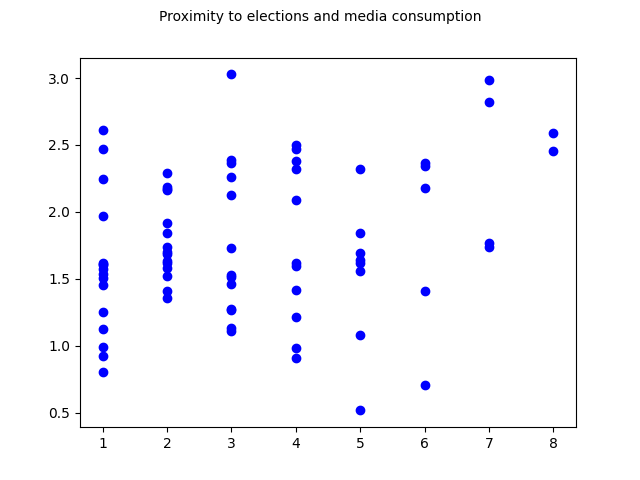

In [54]:
fig, ax = plt.subplots()
fig.suptitle('Proximity to elections and media consumption', fontsize=10)

line, = ax.plot(df_means["Quarters_until_election"],df_means["All"], "bo")

country = "All"
media = "All"

def update():

    global country
    global media

    if country == "All":
        df_country = df_means
    else:
        df_country = df_means[df_means["COUNTRY"] == country]

    line.set_data(df_country["Quarters_until_election"],df_country[media])
    fig.canvas.draw()


def update_country(ucountry = 'All'):
    global country
    country = ucountry.new
    update()

def update_media(umedia = "All"):
    global media
    media = umedia.new
    update()


dropdown_country = widgets.Dropdown(
    value = 'All', 
    options = sorted(np.append(df["COUNTRY"].unique(),["All"])),
    description = 'Country'
)

dropdown_media = widgets.Dropdown(
    value = "All",
    options = sorted(['Radio', 'TV', 'Newspaper', 'Internet', 'Social Media', "All"]),
    description = "Media source"   
)


dropdown_country.observe(update_country, "value")
dropdown_media.observe(update_media,"value")



widgets.VBox(
    [
        dropdown_country,
        dropdown_media
    ]
)
